#First DCGAN 

This should prevent the over specialization in a few items that the original model had

##Imports 

In [3]:
import tensorflow as tf
import tensorflow.keras as keras 

import numpy as np
import matplotlib.pyplot as plt 
from IPython import display

#Utilities 

In [4]:
def plot_results(images, n_cols=None, epoch=0):
  """Visualize fake images"""
  display.clear_output(wait=False)

  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  
  fig = plt.figure(figsize=(n_cols, n_rows))
  fig.suptitle(f"Epochs {epoch}", fontsize="x-large")

  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

#Download and Prepare the Dataset 

Use the Fashion MNIST dataset. Only use the training images.

In [5]:
#download the training images 
(X_train, _), _ = keras.datasets.fashion_mnist.load_data()

#normalize the pixel values 
X_train = X_train.astype(np.float32) / 255

#Reshape and rescale 
X_train = X_train.reshape(-1, 28, 28, 1) * 2 - 1.

BATCH_SIZE = 128

#Create batches of tensors to be fed into the model 
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)

4431872/4422102 [==============================] - 0s 0us/step


#Build the Model 

In DCGANS, convolutional layers are mostly used to build the generator and discriminator. 

#Generator 

The goal here is the same as the previous models: Take in noise and eventually transform it in the training data images.

The general steps are:
* Feed the input noise to a Dense layer 
* Reshape the output to have three dimensions (l, w, n_filters)
* Perform a deconvolutions (`Conv2DTranspose`), reducing the number of filters by half and using a stride of `2`
* the final layer upsamples the features to the size of the training images (`28 x 28 x 1`)

NOTE: Batch normalization is performed except for the final deconvolution layer. Best practiced is to use `selu` for the activation for the intermediate deconvolution while `tanh` is for the output

In [6]:
codings_size = 32

generator = keras.models.Sequential([
        keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
        keras.layers.Reshape([7, 7, 128]),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME', activation='selu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='SAME', activation='tanh')
])

Shape of the generated batch: (16, 28, 28, 1)


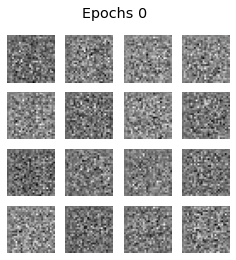

In [7]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, codings_size])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4, epoch=0)

print(f"Shape of the generated batch: {test_image.shape}")

#Discriminator 

This will use strided convolutions to reduce the dimensionality of the input images
* These convolutions will be activated by `LeakyRELU` 
The output features will be flattened and fed to a 1-unit dense layer activated by a `sigmoid` function

In [8]:
discriminator = keras.models.Sequential([
          keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='SAME', activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
          keras.layers.Dropout(0.4),
          keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='SAME', activation=keras.layers.LeakyReLU(0.2)),
          keras.layers.Flatten(),
          keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
gan = keras.models.Sequential([generator, discriminator])

#Configure the Model for Training

Use the same settings as the original model since the discriminator will be still calssifying fake and real images 

In [10]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

#Train the Model

The training loop is identical to the previous models 

In [11]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images, 16, epoch)                     
        plt.show()     

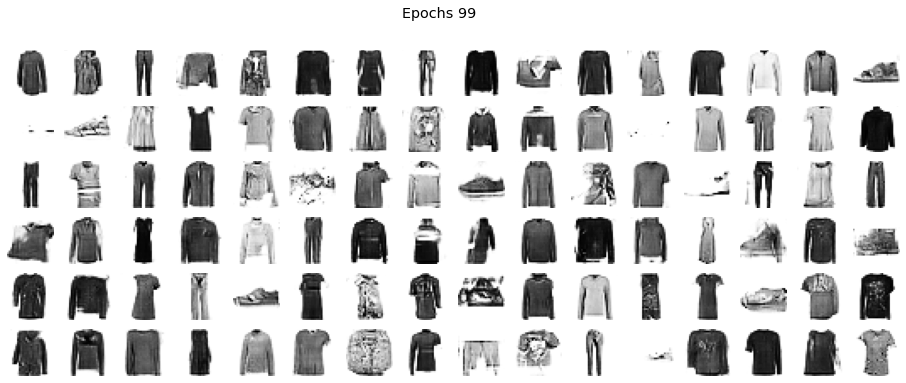

In [12]:
train_gan(gan, dataset, codings_size, 100)